## 🐬 Описание проекта


*   Исследование проводилось для кадрового агентства, предоставившего данные по закрытию вакансий за период 2023 - начало 2024 года.
*   Цель (формулировка в ТЗ)
Выявить признаки вакансий, привлекающих наибольшее внимание кандидатов и успешно закрывающихся силами агентства. В рамках выполнения данной задачи можно использовать любые методы и средства, даже если они не описаны в ТЗ.







## 🪼В этом ноутбуке продолжение [исследований](https://docs.google.com/spreadsheets/d/1HjNH6JRjQz9TJ_6DcXCofrh4xAIzBE84/edit?usp=drive_link&ouid=108036727568364940970&rtpof=true&sd=true), проведенных Марией и попытка немного по-другому обработать категориальные и текстовые признаки

Основные отличия:
- мультилейбл для типа занятости, образования, опыта и формата работы
- уменьшение числа уникальных значений для городов
- убрать курсы из признаков (насколько можно понять - это служебная информация, которую кандидат не видит)
- tiny bert  вместо bert. В дальнейшем можно попробовать прикрутить суммаризацию, чтобы исключить повторы
- тестовое задание - есть/нет
- для названия позиции введена дополнительная фича - грейд
- метод кластеризации по профессиям -  оставлен ручной с небольшими модификациями
- города - разделены на наиболее крупные и все остальные, исключены неявные дубликаты

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.6 MB/s eta 0:00:00


In [3]:
# !pip -q install pymorphy2

In [4]:
import pandas as pd
import warnings
import copy
import re
import os
import numpy as np
import torch
from tqdm import tqdm
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
# import pymorphy2
# from pymorphy2 import MorphAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import joblib
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from pymystem3 import Mystem


import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


RANDOM_STATE = 2004
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize

# nltk.download('stopwords')
# from nltk.corpus import names, stopwords, words
# from wordcloud import WordCloud, STOPWORDS
# STOPWORDS = set(stopwords.words('russian'))
# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer

## 🐚 Загрузка данных

In [5]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/vacancies/vacancy_statistics_2023.xlsx', index_col=False)

In [6]:
df.sample(5)

,id,Статус,Источник лида,Менеджер,Дата публикации,Дата закрытия,Количество просмотров,Количество откликов,Компания,Позиция,Курсы ЯП,Зарплата от,Зарплата до,Город,Формат оформления,Формат работы,Опыт,Образование,Ссылка на тестовое,Занятость,Обязательные требования,Дополнительный требования,Этапы отбора,Условия
72,368,Закрыта нами,Повторная,Кариаули,2023-01-27,2023-02-06,31,20,Atsearch - Crowd Recruitment,IT рисерчер,IT-рекрутер,35000.0,40000.0,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой дог...","Гибрид, Удаленка","Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,Полная,- Знание IT рекрутмента (понимание языков разр...,"Если у вас есть опыт работы с людьми или опыт,...",1. Скрининг резюме_x000D_\n2. Интервью №1_x000...,100% удалёнка или гибридная занятость в офисе ...
1014,1687,Закрыта нами,Повторная,Фаткуллин,2023-09-19,2023-09-27,42,11,YouCreator,Тестировщик на проект,"QA Bootcamp, Инженер по тестированию",NaN,NaN,Москва,"Самозанятость, Контракт, ИП, ГПХ",Удаленка,"Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,"Стажировка, Проектная",Основы тестирования_x000D_\nREST API_x000D_\nБ...,NaN,1. Скрининг резюме_x000D_\n2. Собеседование,Проектная работа со стартапом_x000D_\nСрок раб...
1226,1974,Закрыта нами,Повторная,Фаткуллин,2023-11-26,2023-12-21,44,10,Re-Action.Online (стартап),Data Scientist,"Специалист по Data Science плюс, Data Science ...",NaN,NaN,Москва,"Самозанятость, ИП",Удаленка,"Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,"Стажировка, Проектная","• Знание Python и его библиотек (numpy, pandas...",NaN,1. Скрининг резюме _x000D_\n2. Собеседование,"• Создавай сервис, с помощью которого сам буде..."
904,1532,Архив,Реферальная,Фаткуллин,2023-08-24,2023-10-19,8,1,YouTool,Product Manager,"Продакт-менеджер, Junior Продакт, Middle Продакт",60000.0,80000.0,Москва,"Самозанятость, Трудовой договор",Гибрид,"Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,Полная,"Инструменты для командной работы, умение работ...",NaN,1. Скрининг резюме _x000D_\n2. Собеседование с...,-Очень желательно 2-3 раза в неделю работать в...
18,297,Закрыта нами,Повторная,Кариаули,2023-01-13,2023-01-30,19,6,Гиперион,Junior Python разработчик,"Python-разработчик плюс, Python-Разработчик",NaN,NaN,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой дог...","Офис, Гибрид","Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,Полная,⁃ программирование на Python _x000D_\n ⁃ знани...,NaN,1. Скрининг_x000D_\n2. Интервью,Офисная работа в _x000D_\n_x000D_\n-гибкий гра...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1302 non-null   int64  
 1   Статус                     1302 non-null   object 
 2   Источник лида              1292 non-null   object 
 3   Менеджер                   1209 non-null   object 
 4   Дата публикации            1302 non-null   object 
 5   Дата закрытия              1144 non-null   object 
 6   Количество просмотров      1302 non-null   int64  
 7   Количество откликов        1302 non-null   int64  
 8   Компания                   1302 non-null   object 
 9   Позиция                    1302 non-null   object 
 10  Курсы ЯП                   1302 non-null   object 
 11  Зарплата от                476 non-null    float64
 12  Зарплата до                377 non-null    float64
 13  Город                      1302 non-null   objec

In [8]:
df=df.rename(columns={'Статус':'status', 'Источник лида':'lead_source', 'Менеджер':'manager', 'Дата публикации':'start_date', 'Дата закрытия':'end_date', 'Количество просмотров':'views',
'Количество откликов':'responses', 'Компания':'emp_brand',  'Позиция':'job_title', 'Курсы ЯП':'courses','Зарплата от':'salary_min', 'Зарплата до':'salary_max', 'Город':'city', 'Формат оформления':'contract', 'Формат работы':'format', 'Опыт':'experience', 'Образование':'education', 'Занятость':'employment', 'Ссылка на тестовое':'test_task', 'Обязательные требования':'mandatory', 'Дополнительный требования':'additional', 'Этапы отбора':'comр_stages', 'Условия':'work_conditions'
})

In [9]:
df['target'] = df['responses'] / df['views']

In [10]:
df['test_task'] = df['test_task'].apply(lambda x: 1 if (x is not None) else 0)

In [11]:
df = df.drop(columns=['id','status','lead_source','manager', 'start_date', 'end_date', 'views', 'responses', 'courses'], axis=1)

In [12]:
df['emp_brand'] = df['emp_brand'].apply(lambda x: x.lower().strip())

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   emp_brand        1302 non-null   object 
 1   job_title        1302 non-null   object 
 2   salary_min       476 non-null    float64
 3   salary_max       377 non-null    float64
 4   city             1302 non-null   object 
 5   contract         1302 non-null   object 
 6   format           1302 non-null   object 
 7   experience       1302 non-null   object 
 8   education        1302 non-null   object 
 9   test_task        1302 non-null   int64  
 10  employment       1302 non-null   object 
 11  mandatory        1302 non-null   object 
 12  additional       674 non-null    object 
 13  comр_stages      1302 non-null   object 
 14  work_conditions  1302 non-null   object 
 15  target           1302 non-null   float64
dtypes: float64(3), int64(1), object(12)
memory usage: 162.9+ KB


## 🦈 Профессии и грейды

In [14]:
def grade(txt: str) -> str:
    grds = ['intern', 'junior', 'middle', 'senior', 'lead']
    patterns = [['intern', 'интерн', 'стаж', 'ассист', 'помощ'],
                ['juni', 'младш', 'джун'],
                 ['middle', 'мидл', 'средн'],
                 ['senior', 'сеньор', 'старш'],
                  ['lead', 'ведущ', 'тимлид']]
    result = 'unknown'
    for g, p in zip(grds, patterns):
        matches = [x for x in p if x in txt.lower()]
        if len(matches) != 0:
            result = g
            pass # first match
    return result

In [15]:
df['grade'] = df['job_title'].apply(grade)

<Axes: >

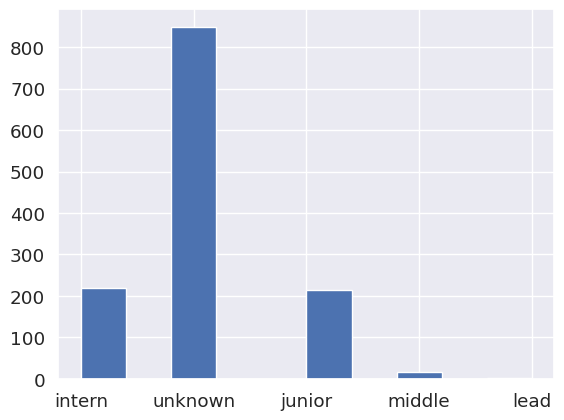

In [16]:
df['grade'].hist()

In [17]:
def prof(txt: str) -> str:
    profs = ['developer', 'devops', 'ds', 'analyst', 'manager',
             'tester', 'designer', 'marketolog', 'support', 'hr']
    patterns = [['develop', 'разработ', 'программист'],
                ['devops', 'ops'],
                 ['ds', 'scien', 'саен', 'сайен', 'ml', 'nlp', 'машин'],
                 ['аналит', 'analyst', 'данны'],
                  ['pm', 'менеджер', 'руководитель', 'manager', 'куратор', 'администр'],
                ['качеств', 'тест', 'test', 'qa'],
                ['design', 'ux', 'ui', 'дизайн'],
                ['таргет', 'market', 'маркет', 'контекст', 'smm', 'seo'],
                ['support', 'техподдер', 'поддерж', 'забот'],
                ['recruit', 'hr', 'сорсер', 'рекрут', 'ресечер', 'рисерчер']]
    result = 'other'
    for pr, pt in zip(profs, patterns):
        matches = [x for x in pt if x in txt.lower()]
        if len(matches) != 0:
            result = pr
            pass
    return result

In [18]:
df['profession'] = df['job_title'].apply(prof)

In [19]:
df = df.drop(['job_title'], axis=1)

## 🐙 Города

Строго говоря, сюда надо подтягивать geopandas и geonames. Пока что в качестве временной меры сделаем категории Москва, СПб, Екб и все остальное

In [20]:
def outside_the_mkad(txt: str) -> str:
    patterns = [['москв', 'маскв', 'москов'],
                ['петерб', 'санкт', 'спб', 'питер'],
                ['екб', 'екатеринб']]
    cities = ['Moscow', 'Saint-Petersburg', 'Yekaterinburg']
    result = 'Other'
    for c, pt in zip(cities, patterns):
        matches = [x for x in pt if x in txt.lower()]
        if len(matches) != 0:
            result = c
            pass
    return result

In [21]:

df['location'] = df['city'].apply(outside_the_mkad)

<Axes: >

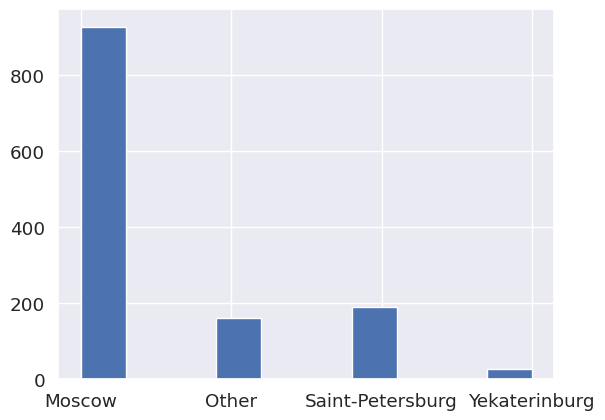

In [22]:
df['location'].hist()

In [23]:
df = df.drop(['city'], axis=1)

## 🪸 Опыт, образования, условия работы

In [24]:
def labels(data: pd.DataFrame, column: str):
    vals = data[column].unique()
    all_vals = ','.join(list(vals))
    all_vals = re.sub(r'\((.*?)\)', r'', all_vals).split(',')
    all_vals = list(map(lambda x: x.strip(), all_vals))
    un_vals = list(set(all_vals))
    for u in un_vals:
        data[u] = data[column].apply(lambda x: 1 if u in x else 0)

In [25]:
labels(df, 'experience')

In [26]:
df = df.rename(columns={'Релевантный': 'relevant_exp',
                   'Около-релевантный': 'near_exp',
                   'Есть только учебный опыт в Практикуме': 'student_exp'})
df = df.drop(['experience'], axis=1)

In [27]:
labels(df, 'education')

In [28]:
df = df.rename(columns={'Профильное': 'relevant_edu',
                   'Около-релевантное': 'near_edu',
                   'Другое': 'other_edu'})
df = df.drop(['education'], axis=1)

In [29]:
labels(df, 'format')

In [30]:
labels(df, 'contract')

In [31]:
df = df.rename(columns={'Удаленка': 'remote',
                   'Офис': 'office',
                   'Гибрид': 'hybrid',
                        'ГПХ': 'gph',
                        'Контракт': 'temporary',
                        'Трудовой договор': 'permanent',
                        'Самозанятость': 'self_empl',
                        'ИП': 'ind_enterp'})
df = df.drop(['format', 'contract'], axis=1)

In [32]:
labels(df, 'employment')

In [33]:
df = df.rename(columns={'Проектная': 'project',
                   'Частичная': 'part_time',
                   'Полная': 'full_time',
                        'Стажировка': 'internship',
                        'Волонтерство': 'volunteering'})
df = df.drop(['employment'], axis=1)

## 🐡 Заполнение пропусков

In [34]:
df['additional']= df['additional'].fillna(' или ')

In [35]:
# df['salary_min'] = df.groupby("profession")['salary_min'].transform(lambda x: x.fillna(x.median()))
# df['salary_max'] = df.groupby("profession")['salary_max'].transform(lambda x: x.fillna(x.median()))

In [36]:
df['description'] = df['mandatory'] + df['additional'] + df['comр_stages'] + df['work_conditions']
df['emp_brand'] = df['emp_brand'] + ' '
df['description_1'] = df['emp_brand'] + df['mandatory'] + df['additional'] + df['comр_stages'] + df['work_conditions']
df = df.drop(['mandatory', 'additional', 'comр_stages', 'work_conditions'], axis=1)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   emp_brand      1302 non-null   object 
 1   salary_min     476 non-null    float64
 2   salary_max     377 non-null    float64
 3   test_task      1302 non-null   int64  
 4   target         1302 non-null   float64
 5   grade          1302 non-null   object 
 6   profession     1302 non-null   object 
 7   location       1302 non-null   object 
 8   near_exp       1302 non-null   int64  
 9   student_exp    1302 non-null   int64  
 10  relevant_exp   1302 non-null   int64  
 11  relevant_edu   1302 non-null   int64  
 12  other_edu      1302 non-null   int64  
 13  near_edu       1302 non-null   int64  
 14  remote         1302 non-null   int64  
 15  office         1302 non-null   int64  
 16  hybrid         1302 non-null   int64  
 17  ind_enterp     1302 non-null   int64  
 18  gph     

## 🦭 Text Processing (Tiny Bert)

---



In [38]:
def cleaner(txt: str) -> str:
    txt = re.sub(r'\_(.*?)\_', r'', txt)
    txt = re.sub(r'([\n\t]*)', r'', txt)
    return txt

In [39]:
example = df['description'][154]
print(example)
print('_'*50)
cleaner(example)

Кого мы ищем:_x000D_
_x000D_
- Мистера или Мисс Обаяние, самого очаровательного рекрутера;_x000D_
- Настойчивого, но ненавязчивого, любящего людей человека;_x000D_
- Рекрутера с опытом в подборе ИЛИ кандидата без опыта, жаждущего влиться в новый увлекательный мир IT-подбора;_x000D_
- Разговорный английский от B1-B2 обязателен. или - Телефонный созвон с HRD _x000D_
- Интервью в zoom с командой_x000D_
Если тебя заинтересовала наша вакансия, пожалуйста, расскажи о своем самом большом профессиональном достижении в сопроводительном письме.- Мы не берем в работу неконкурентоспособные вакансии. - Никаких зарплат ниже рынка, скучных задач и мертвых стеков. _x000D_
- Удаленка, оплата в долларах, релокейт - мы выбираем только такие позиции;_x000D_
- Возможность познакомиться с системами подбора лучших компаний мира;_x000D_
- Мы обучаем сами и привлекаем спикеров со стороны, чтобы усилить скиллы наших рекрутеров;_x000D_
- Мы достойно оплачиваем работу: рекрутер получает оклад, а также от 10 до 25

'Кого мы ищем:- Мистера или Мисс Обаяние, самого очаровательного рекрутера;- Настойчивого, но ненавязчивого, любящего людей человека;- Рекрутера с опытом в подборе ИЛИ кандидата без опыта, жаждущего влиться в новый увлекательный мир IT-подбора;- Разговорный английский от B1-B2 обязателен. или - Телефонный созвон с HRD - Интервью в zoom с командойЕсли тебя заинтересовала наша вакансия, пожалуйста, расскажи о своем самом большом профессиональном достижении в сопроводительном письме.- Мы не берем в работу неконкурентоспособные вакансии. - Никаких зарплат ниже рынка, скучных задач и мертвых стеков. - Удаленка, оплата в долларах, релокейт - мы выбираем только такие позиции;- Возможность познакомиться с системами подбора лучших компаний мира;- Мы обучаем сами и привлекаем спикеров со стороны, чтобы усилить скиллы наших рекрутеров;- Мы достойно оплачиваем работу: рекрутер получает оклад, а также от 10 до 25% от оклада нанятого разработчика;- Полностью удаленная работа;- Мы веселые и экологичн

In [40]:
df['description'] = df['description'].apply(cleaner)

In [41]:
df['description_1'] = df['description_1'].apply(cleaner)

In [42]:
df['seqlen'] = df['description'].apply(lambda x: len(x))
q1 = df['seqlen'].quantile(.05)
q2 = df['seqlen'].quantile(.95)
df = df.loc[(df['seqlen'] > q1) & (df['seqlen'] < q2)]
df['seqlen'].describe()

count    1170.000000
mean      823.358974
std       297.216041
min       307.000000
25%       583.000000
50%       796.000000
75%      1054.000000
max      1488.000000
Name: seqlen, dtype: float64

In [43]:
df = df.drop(['seqlen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 1301
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   emp_brand      1170 non-null   object 
 1   salary_min     425 non-null    float64
 2   salary_max     337 non-null    float64
 3   test_task      1170 non-null   int64  
 4   target         1170 non-null   float64
 5   grade          1170 non-null   object 
 6   profession     1170 non-null   object 
 7   location       1170 non-null   object 
 8   near_exp       1170 non-null   int64  
 9   student_exp    1170 non-null   int64  
 10  relevant_exp   1170 non-null   int64  
 11  relevant_edu   1170 non-null   int64  
 12  other_edu      1170 non-null   int64  
 13  near_edu       1170 non-null   int64  
 14  remote         1170 non-null   int64  
 15  office         1170 non-null   int64  
 16  hybrid         1170 non-null   int64  
 17  ind_enterp     1170 non-null   int64  
 18  gph          

In [44]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

def embed_bert_cls(text):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls(example).shape)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

(312,)


In [45]:
# emb_result = np.array(list(map(lambda x: 'emb_' + str(x), range(312))))
# emb_result = np.expand_dims(emb_result, axis=0)
# for data in tqdm(df['description'].values, desc='Creating embeddings'):
#     res = np.expand_dims(embed_bert_cls(data), axis=0)
#     emb_result = np.concatenate((emb_result, res), axis=0)

In [46]:
# emb_result.shape

In [47]:
# dfe = pd.DataFrame(data=emb_result[1:,:], columns=emb_result[0,:])
# dfe.head()

In [48]:
class VacClass(Dataset):
    def __init__(self, annotations, thr: list):
        self.annotations = annotations
        self.threshold = thr

    def __getitem__(self, idx):
        txt_ = self.annotations['description_1'].values[idx]
        target = self.annotations['target'].values[idx]
        if target < self.threshold[0]:
            target = 0
        elif self.threshold[0] < target < self.threshold[1]:
            target = 1
        else:
            target = 2
        return [txt_], torch.tensor(target)

    def __len__(self):
        return len(self.annotations)

<Axes: >

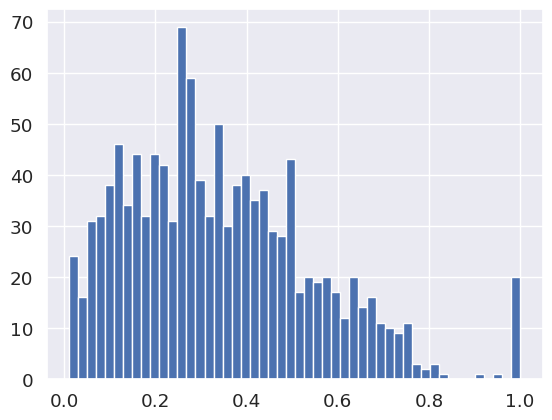

In [49]:
df['target'].hist(bins=50)

In [52]:
def cl(score: float):
    if score < .22:
        return 0
    elif .22 < score < .44:
        return 1
    else:
        return 2
df['classes'] = df['target'].apply(cl)
w = []
for c in df['classes'].unique():
    w.append(len(df.loc[df['classes'] == c]) / len(df))

weights = torch.FloatTensor(w)
weights

tensor([0.3966, 0.3111, 0.2923])

In [53]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device:', device)
SEED = torch.Generator().manual_seed(RANDOM_STATE)
BATCH_SIZE = 32

device: cuda


In [54]:
vac = VacClass(df, [.22, .44])
train_ru, valid_ru = torch.utils.data.random_split(vac, [.8, .2], generator=SEED)
train_dataloader_ru = torch.utils.data.DataLoader(train_ru, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader_ru = torch.utils.data.DataLoader(valid_ru, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [74]:
class TransformerRegrModel(nn.Module):
    def __init__(self, base_transformer_model: str, num_classes: int):
        super().__init__()
        self.tr_model = base_transformer_model
        self.num = num_classes

        if self.tr_model not in  ['rubert', 'base']:
            raise Exception('unknown model')
        elif self.tr_model == 'rubert':
            self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
            self.config = BertConfig.from_pretrained("cointegrated/rubert-tiny2", output_hidden_states=True, output_attentions=True)
        elif self.tr_model == 'base':
            self.tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base", model_max_length=512)
            self.config = BertConfig.from_pretrained("ai-forever/ruBert-base", output_hidden_states=True, output_attentions=True)
        self.model = AutoModel.from_config(self.config)
        self.a1 = nn.ReLU()
        self.classifier_1 = nn.Linear(self.model.pooler.dense.out_features, self.num)
        # self.classifier_dropout = nn.Dropout(p=0.2)
        # self.classifier_2 = nn.Linear(128, self.num)

    def forward(self, inputs):
        t = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')
        tokens = self.tokenizer.convert_ids_to_tokens(t['input_ids'][0])
        model_output = self.model(**{k: v.to(device) for k, v in t.items()})
        attentions = torch.cat(model_output['attentions']).to('cpu')
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        outputs = self.a1(embeddings)
        outputs = self.classifier_1(outputs)
        # outputs = self.classifier_dropout(outputs)
        # outputs = self.a1(outputs)
        # outputs = self.classifier_dropout(outputs)
        # outputs = self.classifier_2(outputs)

        return outputs, tokens, attentions

In [75]:
rubert = TransformerRegrModel('rubert', 3)

In [76]:
txts, labels = next(iter(train_dataloader_ru))
rubert.to(device)
rubert.eval()
res, tokens, attentions = rubert(txts[0])
res

tensor([[0.0124, 0.0008, 0.0711],
        [0.0129, 0.0009, 0.0716],
        [0.0125, 0.0008, 0.0719],
        [0.0123, 0.0010, 0.0716],
        [0.0131, 0.0007, 0.0717],
        [0.0122, 0.0014, 0.0716],
        [0.0128, 0.0012, 0.0716],
        [0.0126, 0.0010, 0.0716],
        [0.0122, 0.0010, 0.0715],
        [0.0133, 0.0009, 0.0711],
        [0.0121, 0.0006, 0.0717],
        [0.0124, 0.0006, 0.0718],
        [0.0122, 0.0011, 0.0708],
        [0.0124, 0.0011, 0.0716],
        [0.0126, 0.0015, 0.0716],
        [0.0124, 0.0011, 0.0713],
        [0.0118, 0.0011, 0.0716],
        [0.0133, 0.0012, 0.0714],
        [0.0125, 0.0008, 0.0717],
        [0.0127, 0.0012, 0.0716],
        [0.0131, 0.0009, 0.0717],
        [0.0124, 0.0008, 0.0718],
        [0.0125, 0.0008, 0.0716],
        [0.0124, 0.0013, 0.0715],
        [0.0131, 0.0011, 0.0716],
        [0.0127, 0.0012, 0.0713],
        [0.0123, 0.0010, 0.0715],
        [0.0130, 0.0011, 0.0717],
        [0.0126, 0.0011, 0.0712],
        [0.012

In [77]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler_down, scheduler_up):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:

        # inputs = inputs[0].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs, _, _ = model(inputs[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * len(inputs[0])
        running_corrects += torch.sum(preds == labels.data)
        processed_data += len(inputs[0])

    scheduler_down.step()
    # scheduler_up.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    rate = optimizer.param_groups[0]["lr"]
    return train_loss, train_acc, rate


In [78]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        # inputs = inputs[0].to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs, _, _ = model(inputs[0])
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * len(inputs[0])
        running_corrects += torch.sum(preds == labels.data)
        processed_size += len(inputs[0])
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [79]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels in test_loader:
            labels = labels.to(device)
            model.eval()
            outputs, _, _ = model(inputs[0])
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += len(inputs[0])

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [80]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc, rate = zip(*h)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
    plt.plot(np.log(rate), label="learning_rate", color='green')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("learning rate (log scale)")
    plt.show()

In [81]:
def freeze_model(model):
    for name, param in model.named_parameters():
        if 'classifier' not in name:
            param.requires_grad = False
    return model

In [82]:
def train_transformer(train, val, model, epochs, rate, criterion, freeze):
    model_ = copy.copy(model)
    if freeze:
        model_ = freeze_model(model_)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}, learning rate {r}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model_.parameters(), lr=rate)
        # sch = StepLR(opt, step_size=5, gamma=0.1)
        sch_down = StepLR(opt, step_size=25, gamma=0.2)
        sch_up = StepLR(opt, step_size=10, gamma=200)

        val_acc_p = 0

        for epoch in range(epochs):
            train_loss, train_acc, rate = fit_epoch(model_, train, criterion, opt, sch_down, sch_up)

            val_loss, val_acc = eval_epoch(model_, val, criterion)
            if val_acc > val_acc_p and epoch != 0:
                torch.save(model_.state_dict(), "/content/drive/MyDrive/Colab Notebooks/vacancies/tiny.pt")
                print(f'save best model for {epoch} epoch')
                val_acc_p = val_acc
            history.append((train_loss, train_acc, val_loss, val_acc, rate))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, r=rate))

    return history, model_

In [83]:
bce = nn.CrossEntropyLoss(weight=weights.to(device))
lr = 3e-4

In [85]:
rubert = rubert.to(device)
graphs, trained_model = train_transformer(train_dataloader_ru, valid_dataloader_ru,
                                                                rubert, epochs=50,
                                                                rate=lr, criterion=bce, freeze=False)

epoch:   2%|▏         | 1/50 [00:21<17:50, 21.84s/it]


Epoch 001 train_loss: 1.0889     val_loss 1.0898 train_acc 0.3376 val_acc 0.3846, learning rate 0.0003


epoch:   4%|▍         | 2/50 [00:42<16:58, 21.21s/it]

save best model for 1 epoch

Epoch 002 train_loss: 1.0856     val_loss 1.0896 train_acc 0.3312 val_acc 0.3846, learning rate 0.0003


epoch:   6%|▌         | 3/50 [01:01<15:57, 20.37s/it]


Epoch 003 train_loss: 1.0853     val_loss 1.0893 train_acc 0.4006 val_acc 0.3120, learning rate 0.0003


epoch:   8%|▊         | 4/50 [01:21<15:25, 20.11s/it]

save best model for 3 epoch

Epoch 004 train_loss: 1.0850     val_loss 1.0890 train_acc 0.3643 val_acc 0.3932, learning rate 0.0003


epoch:  10%|█         | 5/50 [01:40<14:48, 19.74s/it]


Epoch 005 train_loss: 1.0337     val_loss 1.1048 train_acc 0.5524 val_acc 0.3761, learning rate 0.0003


epoch:  12%|█▏        | 6/50 [01:59<14:10, 19.32s/it]


Epoch 006 train_loss: 0.9044     val_loss 1.1224 train_acc 0.6635 val_acc 0.3248, learning rate 0.0003


epoch:  14%|█▍        | 7/50 [02:18<13:45, 19.20s/it]


Epoch 007 train_loss: 0.7954     val_loss 1.1197 train_acc 0.7949 val_acc 0.3846, learning rate 0.0003


epoch:  16%|█▌        | 8/50 [02:37<13:27, 19.23s/it]


Epoch 008 train_loss: 0.6875     val_loss 1.1781 train_acc 0.8921 val_acc 0.3803, learning rate 0.0003


epoch:  18%|█▊        | 9/50 [02:55<12:56, 18.94s/it]


Epoch 009 train_loss: 0.7430     val_loss 1.2146 train_acc 0.6923 val_acc 0.3718, learning rate 0.0003


epoch:  20%|██        | 10/50 [03:18<13:20, 20.00s/it]

save best model for 9 epoch

Epoch 010 train_loss: 0.6921     val_loss 1.1922 train_acc 0.7244 val_acc 0.4017, learning rate 0.0003


epoch:  22%|██▏       | 11/50 [03:37<12:46, 19.67s/it]


Epoch 011 train_loss: 0.6039     val_loss 1.2368 train_acc 0.8675 val_acc 0.3974, learning rate 0.0003


epoch:  24%|██▍       | 12/50 [03:57<12:38, 19.96s/it]

save best model for 11 epoch

Epoch 012 train_loss: 0.4744     val_loss 1.2338 train_acc 0.9498 val_acc 0.4231, learning rate 0.0003


epoch:  26%|██▌       | 13/50 [04:16<12:05, 19.60s/it]


Epoch 013 train_loss: 0.4043     val_loss 1.3371 train_acc 0.9712 val_acc 0.4017, learning rate 0.0003


epoch:  28%|██▊       | 14/50 [04:36<11:44, 19.57s/it]


Epoch 014 train_loss: 0.3620     val_loss 1.3358 train_acc 0.9701 val_acc 0.4060, learning rate 0.0003


epoch:  30%|███       | 15/50 [04:54<11:12, 19.20s/it]


Epoch 015 train_loss: 0.3294     val_loss 1.4596 train_acc 0.9701 val_acc 0.3761, learning rate 0.0003


epoch:  32%|███▏      | 16/50 [05:13<10:50, 19.14s/it]


Epoch 016 train_loss: 0.3000     val_loss 1.4028 train_acc 0.9690 val_acc 0.4103, learning rate 0.0003


epoch:  34%|███▍      | 17/50 [05:32<10:26, 19.00s/it]


Epoch 017 train_loss: 0.2688     val_loss 1.4446 train_acc 0.9776 val_acc 0.4145, learning rate 0.0003


epoch:  36%|███▌      | 18/50 [05:51<10:11, 19.12s/it]


Epoch 018 train_loss: 0.2638     val_loss 1.5658 train_acc 0.9679 val_acc 0.4017, learning rate 0.0003


epoch:  38%|███▊      | 19/50 [06:09<09:46, 18.92s/it]


Epoch 019 train_loss: 0.2919     val_loss 1.5671 train_acc 0.9476 val_acc 0.3803, learning rate 0.0003


epoch:  40%|████      | 20/50 [06:29<09:29, 18.99s/it]


Epoch 020 train_loss: 0.2502     val_loss 1.5894 train_acc 0.9626 val_acc 0.4017, learning rate 0.0003


epoch:  42%|████▏     | 21/50 [06:47<09:09, 18.94s/it]


Epoch 021 train_loss: 0.2185     val_loss 1.6970 train_acc 0.9733 val_acc 0.3675, learning rate 0.0003


epoch:  44%|████▍     | 22/50 [07:06<08:47, 18.86s/it]


Epoch 022 train_loss: 0.2053     val_loss 1.7543 train_acc 0.9754 val_acc 0.3632, learning rate 0.0003


epoch:  46%|████▌     | 23/50 [07:26<08:38, 19.22s/it]


Epoch 023 train_loss: 0.1888     val_loss 1.7194 train_acc 0.9786 val_acc 0.3761, learning rate 0.0003


epoch:  48%|████▊     | 24/50 [07:45<08:13, 18.97s/it]


Epoch 024 train_loss: 0.2207     val_loss 1.7510 train_acc 0.9583 val_acc 0.3718, learning rate 0.0003


epoch:  50%|█████     | 25/50 [08:04<07:58, 19.14s/it]


Epoch 025 train_loss: 0.1778     val_loss 1.8140 train_acc 0.9776 val_acc 0.3846, learning rate 5.9999999999999995e-05


epoch:  52%|█████▏    | 26/50 [08:22<07:33, 18.88s/it]


Epoch 026 train_loss: 0.1568     val_loss 1.8510 train_acc 0.9829 val_acc 0.3547, learning rate 5.9999999999999995e-05


epoch:  54%|█████▍    | 27/50 [08:42<07:17, 19.01s/it]


Epoch 027 train_loss: 0.1517     val_loss 1.8521 train_acc 0.9840 val_acc 0.3504, learning rate 5.9999999999999995e-05


epoch:  56%|█████▌    | 28/50 [09:00<06:56, 18.94s/it]


Epoch 028 train_loss: 0.1452     val_loss 1.8802 train_acc 0.9861 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  58%|█████▊    | 29/50 [09:20<06:40, 19.05s/it]


Epoch 029 train_loss: 0.1445     val_loss 1.8901 train_acc 0.9861 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  60%|██████    | 30/50 [09:38<06:18, 18.93s/it]


Epoch 030 train_loss: 0.1438     val_loss 1.8932 train_acc 0.9850 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  62%|██████▏   | 31/50 [09:57<05:58, 18.85s/it]


Epoch 031 train_loss: 0.1377     val_loss 1.8675 train_acc 0.9861 val_acc 0.3547, learning rate 5.9999999999999995e-05


epoch:  64%|██████▍   | 32/50 [10:16<05:40, 18.91s/it]


Epoch 032 train_loss: 0.1371     val_loss 1.8843 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  66%|██████▌   | 33/50 [10:34<05:18, 18.72s/it]


Epoch 033 train_loss: 0.1337     val_loss 1.9019 train_acc 0.9882 val_acc 0.3761, learning rate 5.9999999999999995e-05


epoch:  68%|██████▊   | 34/50 [10:54<05:04, 19.06s/it]


Epoch 034 train_loss: 0.1355     val_loss 1.8867 train_acc 0.9840 val_acc 0.3590, learning rate 5.9999999999999995e-05


epoch:  70%|███████   | 35/50 [11:13<04:42, 18.84s/it]


Epoch 035 train_loss: 0.1362     val_loss 1.8948 train_acc 0.9840 val_acc 0.3675, learning rate 5.9999999999999995e-05


epoch:  72%|███████▏  | 36/50 [11:32<04:25, 18.97s/it]


Epoch 036 train_loss: 0.1316     val_loss 1.8691 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  74%|███████▍  | 37/50 [11:50<04:05, 18.86s/it]


Epoch 037 train_loss: 0.1295     val_loss 1.9044 train_acc 0.9872 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  76%|███████▌  | 38/50 [12:10<03:48, 19.05s/it]


Epoch 038 train_loss: 0.1277     val_loss 1.8972 train_acc 0.9861 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  78%|███████▊  | 39/50 [12:28<03:26, 18.82s/it]


Epoch 039 train_loss: 0.1250     val_loss 1.9199 train_acc 0.9861 val_acc 0.3675, learning rate 5.9999999999999995e-05


epoch:  80%|████████  | 40/50 [12:47<03:07, 18.75s/it]


Epoch 040 train_loss: 0.1228     val_loss 1.8953 train_acc 0.9882 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  82%|████████▏ | 41/50 [13:06<02:49, 18.87s/it]


Epoch 041 train_loss: 0.1207     val_loss 1.9119 train_acc 0.9882 val_acc 0.3675, learning rate 5.9999999999999995e-05


epoch:  84%|████████▍ | 42/50 [13:24<02:30, 18.77s/it]


Epoch 042 train_loss: 0.1181     val_loss 1.9165 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  86%|████████▌ | 43/50 [13:44<02:12, 18.92s/it]


Epoch 043 train_loss: 0.1173     val_loss 1.9237 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  88%|████████▊ | 44/50 [14:02<01:52, 18.72s/it]


Epoch 044 train_loss: 0.1158     val_loss 1.9274 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  90%|█████████ | 45/50 [14:22<01:35, 19.12s/it]


Epoch 045 train_loss: 0.1157     val_loss 1.9433 train_acc 0.9872 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  92%|█████████▏| 46/50 [14:41<01:16, 19.07s/it]


Epoch 046 train_loss: 0.1146     val_loss 1.9500 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  94%|█████████▍| 47/50 [15:00<00:57, 19.13s/it]


Epoch 047 train_loss: 0.1123     val_loss 1.9699 train_acc 0.9882 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  96%|█████████▌| 48/50 [15:19<00:38, 19.03s/it]


Epoch 048 train_loss: 0.1126     val_loss 2.0078 train_acc 0.9882 val_acc 0.3675, learning rate 5.9999999999999995e-05


epoch:  98%|█████████▊| 49/50 [15:38<00:18, 18.92s/it]


Epoch 049 train_loss: 0.1114     val_loss 1.9894 train_acc 0.9872 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch: 100%|██████████| 50/50 [15:56<00:00, 19.14s/it]


Epoch 050 train_loss: 0.1101     val_loss 2.0198 train_acc 0.9893 val_acc 0.3504, learning rate 1.2e-05


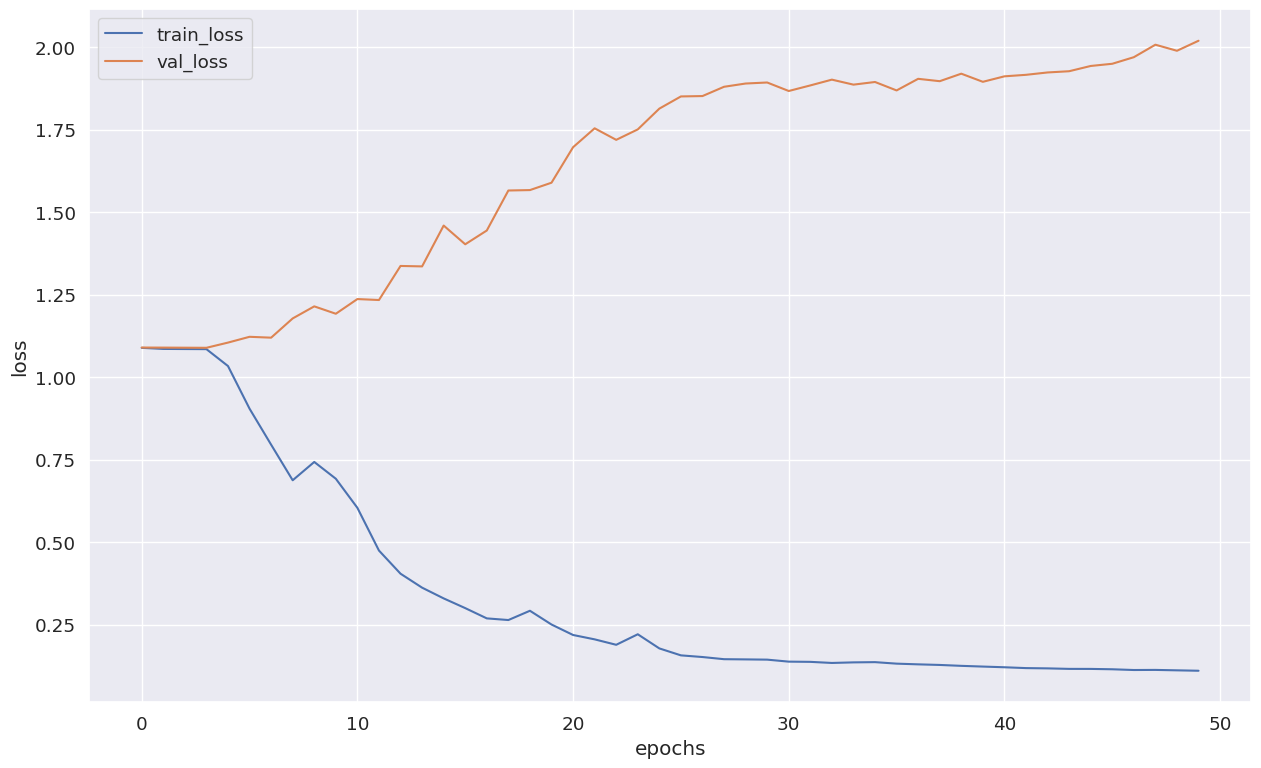

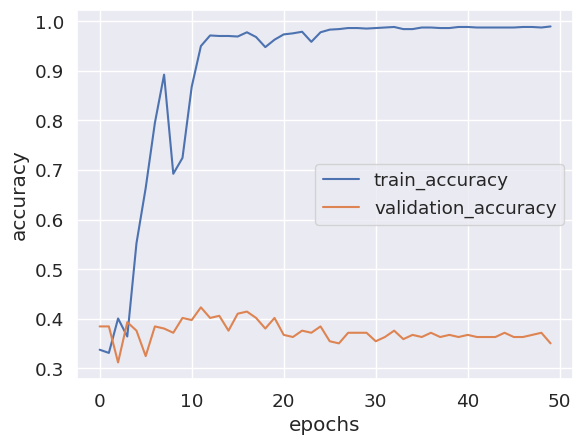

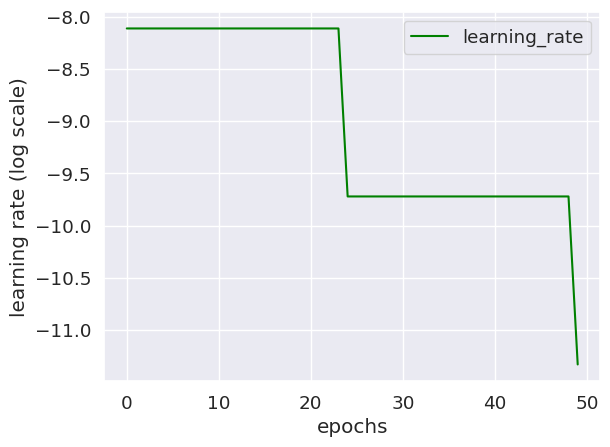

In [86]:
vizualize(graphs, 'RuBert')

In [87]:
tbert = TransformerRegrModel('rubert', 3)
model_path = "/content/drive/MyDrive/Colab Notebooks/vacancies/tiny.pt"
tbert.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
tbert.to(device)
tbert.eval()
result = predict(tbert, valid_dataloader_ru)

In [88]:
CLASSES = {'low': 0,
           'middle': 1,
           'high': 2
}

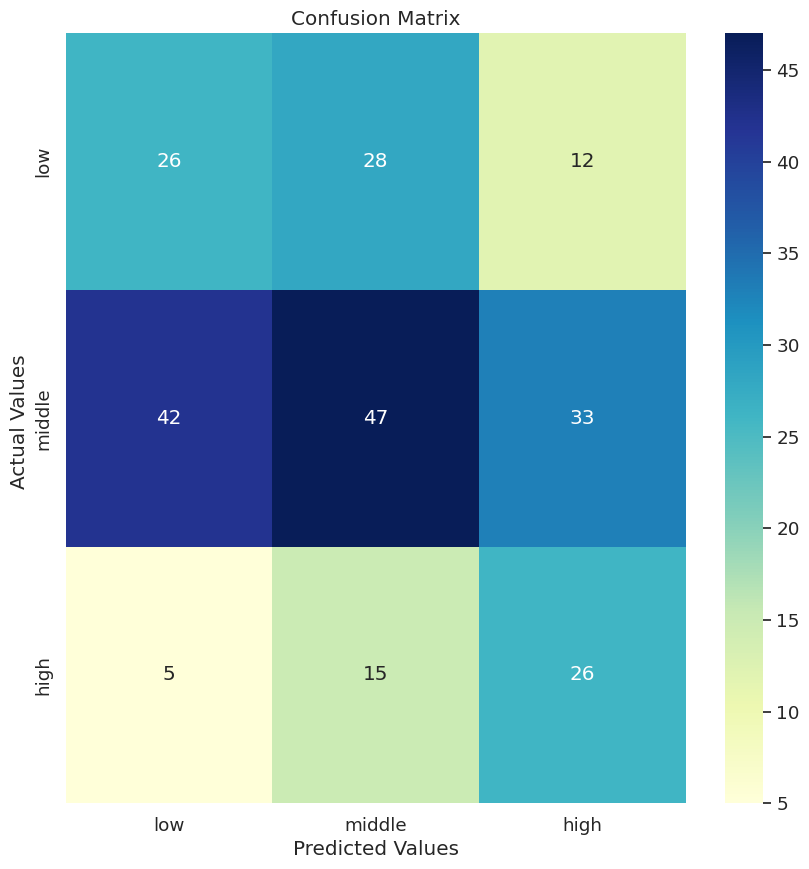

In [89]:
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(list(CLASSES.keys()))
ax.yaxis.set_ticklabels(list(CLASSES.keys()))
plt.show()

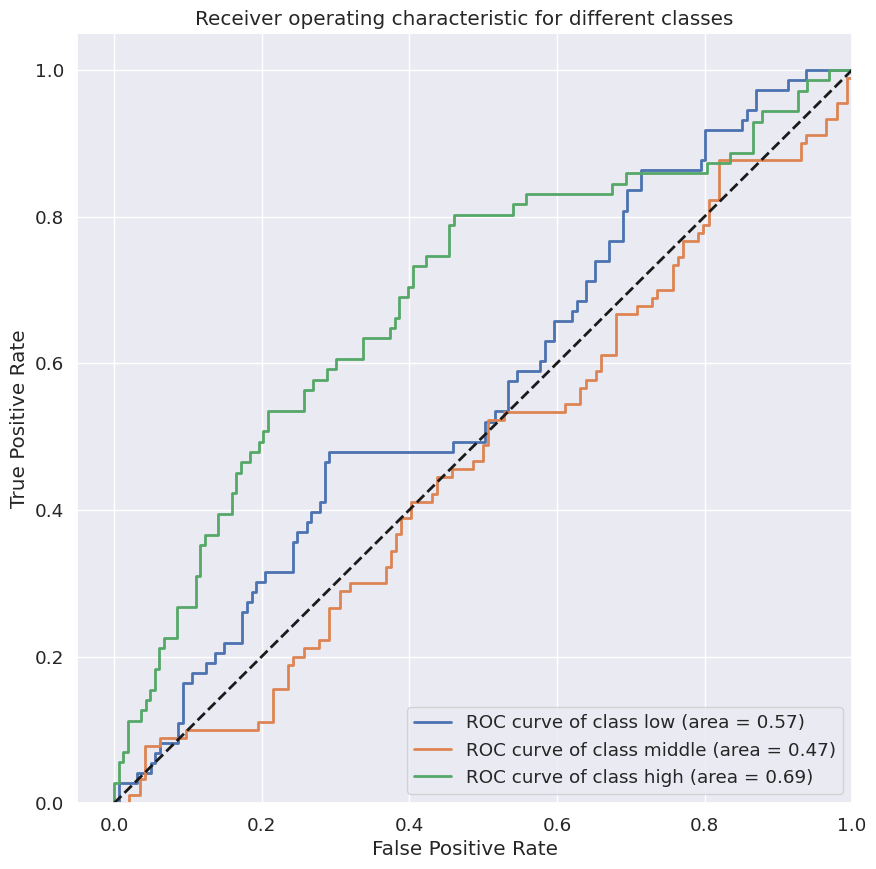

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(CLASSES.values())
labels = list(CLASSES.keys())
label_test = label_binarize(result[0], classes=classes)
n_classes = label_test.shape[1]
y_score = result[2]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes')
plt.legend(loc="lower right")
plt.show()

## 🐳 Результаты

**Режим обучения**

- 45 эпох
- начальная скорость 0,0003
- шедуллер 0,1 с шагом в 15 эпох
- пороги: 0,22-0,66

|Модель|Используемые признаки|Количество слоев классификатора|Дропаут|Заморозка|Accuracy|ROC-AUC по классам|
|-|-|-|-|-|-|-|
|tiny-bert|текстовые описания|1|нет|нет|0,63|0,59/0,56/0,61|
|tiny-bert|текстовые описания|2|нет|нет|0,60|0,54/0,50/0,58|
|tiny-bert|текстовые описания|2|0,1|нет|0,65|0,55/0,59/0,44|
|tiny-bert|текстовые описания|1|0,1|нет|0,63|0,58/0,56/0,53|
|tiny-bert|текстовые описания|1|нет|да|--|обучения не происходит|
|tiny-bert|текстовые описания + названия|1|нет|нет|0,63|0,58/0,51/0,66|
|ru-bert-base|текстовые описания + названия|1|нет|нет|обучения не происходит|--|

- 75 эпох
- начальная скорость 0,0003
- шедуллер 0,2 с шагом в 25 эпох
- пороги 0,22-0,44


|Модель|Используемые признаки|Количество слоев классификатора|Дропаут|Заморозка|Accuracy|ROC-AUC по классам|
|-|-|-|-|-|-|-|
|tiny-bert|текстовые описания + названия|2|0,2|нет|0,41|0,55/0,53/0,59|
|**tiny-bert**|**текстовые описания + названия**|**1**|**нет**|**нет**|**0,42**|**0,57/0,47/0,69**|



## 🐋 CatBoost

In [92]:
def baseline(data: pd.DataFrame, columns: list, cat_features: list, target: list, save=False):
    x_train, x_val, y_train, y_val = train_test_split(data[columns], data[target], random_state=RANDOM_STATE)
    pool_train = Pool(x_train, y_train, cat_features=cat_features)
    pool_val = Pool(x_val, y_val, cat_features=cat_features)
    model = CatBoostRegressor(loss_function='RMSE')
    model.fit(pool_train, eval_set=pool_val, verbose=False, early_stopping_rounds=20)
    res = model.predict(pool_val)
    y_val["pr"] = res
    y_val["diff"] = - y_val["pr"] + y_val["target"]
    r2 = r2_score(y_val["target"], y_val["pr"])
    rmse_score = np.sqrt(mean_squared_error(y_val["target"], y_val["pr"]))
    mape_score = 100*mean_absolute_percentage_error(y_val["target"], y_val["pr"])
    plt.plot(y_val["target"], y_val["diff"], "x")
    plt.title(f'Residuals\nR2 score: {r2:.3f}\n'
              f'RMSE score: {rmse_score:.2f}\n'
              f'RMSE to target median ratio: {rmse_score / y_val["target"].median():.2f}\n'
              f'MAPE score: {mape_score:.2f} %')
    plt.show()
    importances = model.feature_importances_
    importances = pd.Series(importances, index=columns).sort_values(ascending=False)
    importances.plot.bar()
    plt.title("Feature importances")
    plt.ylabel("Mean decrease in impurity")
    plt.show()
    if save:
        name = f'/content/{str(data.shape[0] * data.shape[1])}_cat.joblib'
        joblib.dump(model, name)

In [93]:
columns = df.columns.drop(['target', 'description', 'classes', 'description_1', 'emp_brand', 'salary_min', 'salary_max'])
target = ['target']
cat_features = ['grade', 'profession', 'location']
text = ['description', 'clean_description']

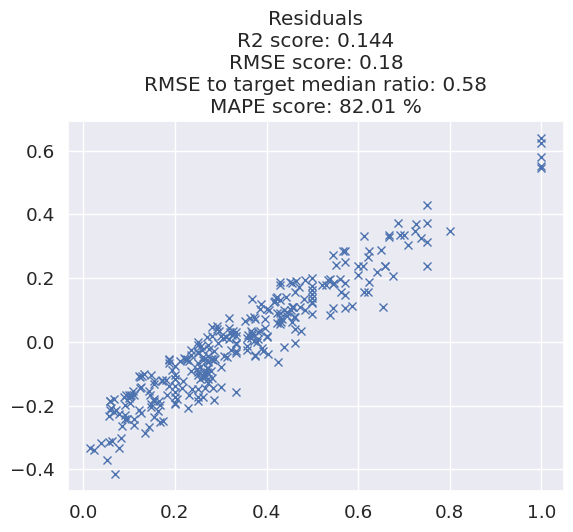

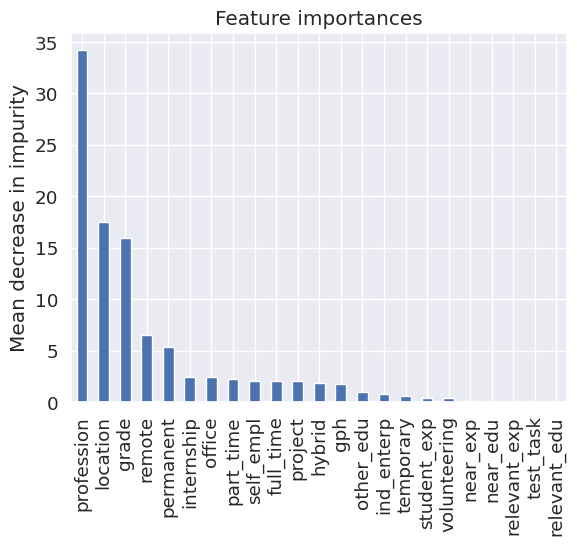

In [94]:
baseline(df, columns, cat_features, target, save=True)

In [ ]:
# df2 = pd.concat([df.reset_index(drop=True), dfe], axis=1)
# columns = df2.columns.drop(['target', 'description'])
# target = ['target']
# cat_features = ['grade', 'profession', 'location']
# text = ['description']

# baseline(df2, columns, cat_features, target)

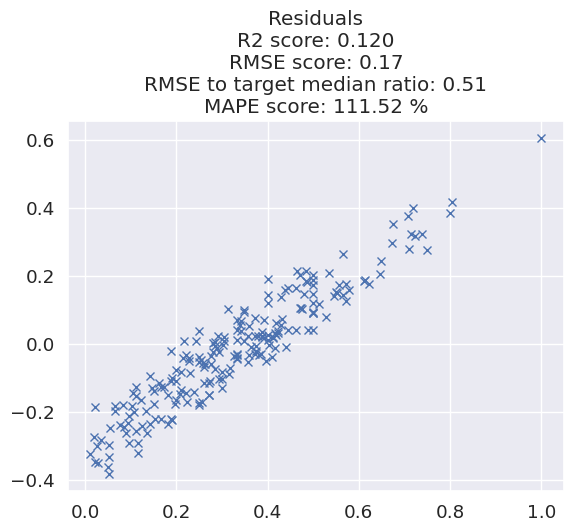

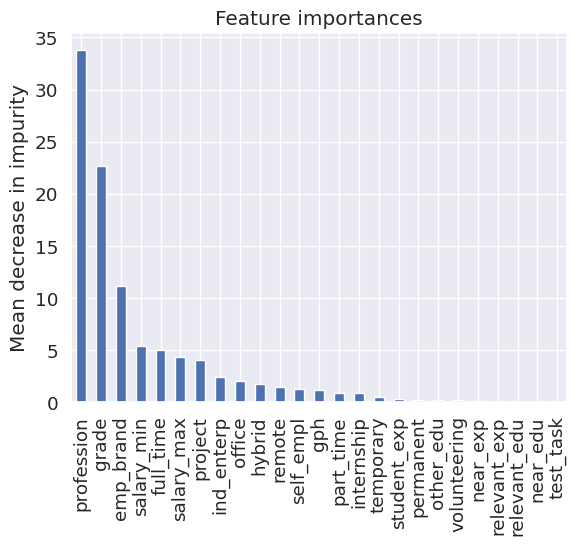

In [ ]:
df2 = df.loc[df['location'] == 'MOW']
columns = df2.columns.drop(['target', 'description', 'location'])
target = ['target']
cat_features = ['grade', 'profession', 'emp_brand']

baseline(df2, columns, cat_features, target)

In [ ]:
# for p in df['profession'].unique():
#    df1 = df.loc[df['profession'] == p]
#    columns = df1.columns.drop(['target', 'description', 'salary_min', 'salary_max', 'profession', 'location', 'grade'])
#    target = ['target']
#    cat_features = ['emp_brand']
#    print(p.upper(), '\n')
#    baseline(df1, columns, cat_features, target)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 1301
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   emp_brand     1170 non-null   object 
 1   salary_min    425 non-null    float64
 2   salary_max    1170 non-null   float64
 3   test_task     1170 non-null   int64  
 4   target        1170 non-null   float64
 5   grade         1170 non-null   object 
 6   profession    1170 non-null   object 
 7   location      1170 non-null   object 
 8   near_exp      1170 non-null   int64  
 9   student_exp   1170 non-null   int64  
 10  relevant_exp  1170 non-null   int64  
 11  other_edu     1170 non-null   int64  
 12  near_edu      1170 non-null   int64  
 13  relevant_edu  1170 non-null   int64  
 14  office        1170 non-null   int64  
 15  remote        1170 non-null   int64  
 16  hybrid        1170 non-null   int64  
 17  permanent     1170 non-null   int64  
 18  self_empl     1170 non-null   int

In [ ]:
df['edu_opt'] = df['other_edu'] + df['near_edu'] + df['relevant_edu']
df['exp_opt'] = df['student_exp'] + df['near_exp'] + df['relevant_exp']
df['format_opt'] = df['office'] + df['remote'] + df['hybrid']
df['contract_opt'] = df['permanent'] + df['gph'] + df['self_empl'] + df['temporary'] + df['ind_enterp']
df['time_opt'] = df['part_time'] + df['full_time'] +df['internship'] + df['volunteering'] + df['project']

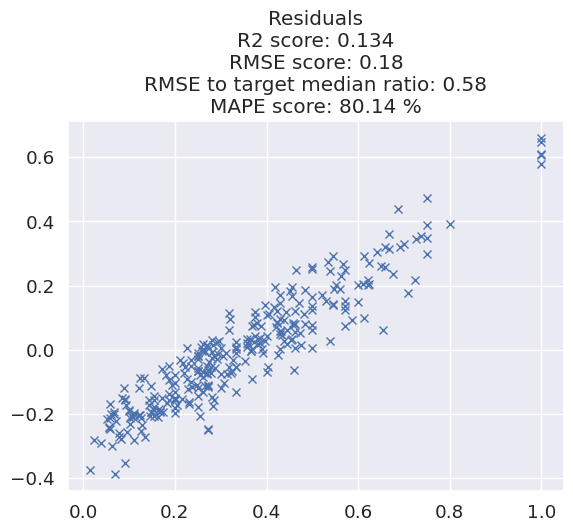

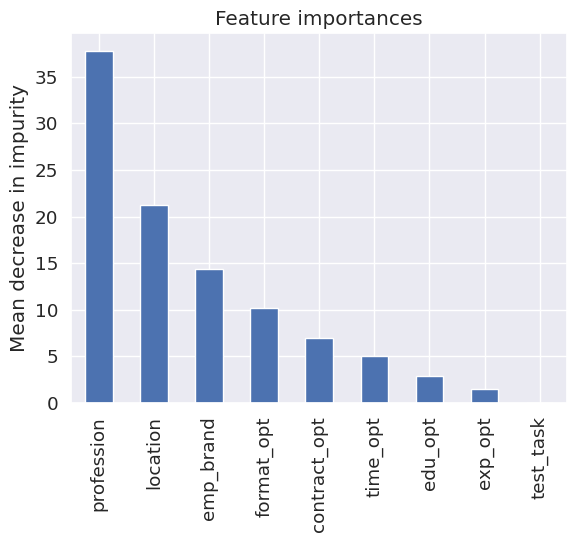

In [ ]:
columns = ['emp_brand', 'test_task',
       'profession', 'location', 'edu_opt', 'exp_opt', 'format_opt', 'contract_opt', 'time_opt']
target = ['target']
cat_features = ['profession', 'emp_brand', 'location']

baseline(df, columns, cat_features, target)

## 🐠 Выводы


- R2-score низкий
- график остатков неприятный
- добавление эмбеддингов в катбуст картину не улучшает
- рассмотрение только москвы тоже принципиально лучше не делает
- предсказания bert-ом прироста в метрике не дают
- кластеризация по профессиям - тоже